In [1]:
import pandas as pd
from datetime import datetime
import pm4py
import numpy as np
from collections import defaultdict
from Levenshtein import distance

from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import copy
import matplotlib as mlp
import matplotlib.pyplot as plt

In [2]:
Order = pm4py.read.read_xes("1_Order.xes")
Loops = pm4py.read.read_xes("2_Loops.xes") 
Skips = pm4py.read.read_xes("3_Skips.xes")
Order_Loops = pm4py.read.read_xes("4_Order_Loops.xes")
Loops_Skips = pm4py.read.read_xes("5_Loops_Skips.xes")
Skips_Order = pm4py.read.read_xes("6_Skips_Order.xes")
Order_Loops_Skips = pm4py.read.read_xes("7_Order_Loops_Skips.xes")


C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 18/18 [00:00<00:00, 17524.95it/s]


In [3]:
Order_log = Order.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Loops_log = Loops.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Skips_log = Skips.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Order_Loops_log = Order_Loops.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Loops_Skips_log = Loops_Skips.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Skips_Order_log = Skips_Order.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
Order_Loops_Skips_log = Order_Loops_Skips.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()

In [4]:
logs = [Order_log, Loops_log, Skips_log, Order_Loops_log, Loops_Skips_log, Skips_Order_log, Order_Loops_Skips_log]

In [5]:
for i in logs:
    print(i)

  case:concept:name     concept:name
0                 1  [A, B, C, D, E]
1                 2  [A, B, D, C, E]
2                 3  [A, C, B, D, E]
3                 4  [A, D, B, C, E]
4                 5  [A, C, D, B, E]
5                 6  [A, D, C, B, E]
  case:concept:name              concept:name
0                 1        [A, B, B, C, D, E]
1                 2        [A, B, C, C, D, E]
2                 3        [A, B, C, D, D, E]
3                 4     [A, B, C, B, C, D, E]
4                 5     [A, B, C, D, C, D, E]
5                 6  [A, B, C, D, B, C, D, E]
  case:concept:name  concept:name
0                 1  [A, C, D, E]
1                 2  [A, B, D, E]
2                 3  [A, B, C, E]
3                 4     [A, D, E]
4                 5     [A, B, E]
5                 6        [A, E]
   case:concept:name              concept:name
0                  1           [A, B, C, D, E]
1                 10     [A, B, C, B, C, D, E]
2                 11     [A, B, C, D, C,

In [7]:
#Change to string format
for i in logs:
    i["strings"] = i["concept:name"].apply(lambda x: ''.join(x))

In [8]:
#Calculate distance matrix based on Levenshtein Distance
from Levenshtein import distance

def Lev(logVar):
    
    List = logVar["strings"]

    n = len(List)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        if i % 200 == 0:
            print(i)
        for j in range(i, n):
            dist_matrix[i,j] = distance(List[i], List[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation

    return dist_matrix

In [10]:
logs_dis

[array([[0., 2., 2., 2., 2., 2.],
        [2., 0., 2., 2., 2., 2.],
        [2., 2., 0., 2., 2., 2.],
        [2., 2., 2., 0., 2., 2.],
        [2., 2., 2., 2., 0., 2.],
        [2., 2., 2., 2., 2., 0.]]),
 array([[0., 1., 2., 1., 2., 2.],
        [1., 0., 1., 1., 1., 2.],
        [2., 1., 0., 2., 1., 2.],
        [1., 1., 2., 0., 1., 1.],
        [2., 1., 1., 1., 0., 1.],
        [2., 2., 2., 1., 1., 0.]]),
 array([[0., 1., 2., 1., 2., 2.],
        [1., 0., 1., 1., 1., 2.],
        [2., 1., 0., 2., 1., 2.],
        [1., 1., 2., 0., 1., 1.],
        [2., 1., 1., 1., 0., 1.],
        [2., 2., 2., 1., 1., 0.]]),
 array([[0., 2., 2., 3., 2., 2., 2., 2., 2., 1., 1., 1.],
        [2., 0., 1., 1., 3., 2., 3., 4., 3., 1., 1., 2.],
        [2., 1., 0., 1., 2., 3., 4., 3., 3., 2., 1., 1.],
        [3., 1., 1., 0., 3., 3., 3., 3., 4., 2., 2., 2.],
        [2., 3., 2., 3., 0., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 3., 3., 2., 0., 2., 2., 2., 2., 2., 2.],
        [2., 3., 4., 3., 2., 2., 0

In [11]:
#Average Levenshtein distance
for i in range(len(logs_dis)):
    variety = np.average(logs_dis[i])
    print(str(i)+':', variety)

0: 1.6666666666666667
1: 1.1666666666666667
2: 1.1666666666666667
3: 2.0
4: 2.25
5: 1.7083333333333333
6: 2.2037037037037037


# Variety

In [29]:
#Calculate linkage Matrix
from scipy.cluster.hierarchy import linkage

#Distances after clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import squareform

#For Evaluation
from scipy.integrate import simpson
from numpy import trapz
import scipy.stats
from scipy.cluster.hierarchy import fcluster

In [14]:
#Change to string format
logs_link = ['Order_log_link', 'Loops_log_link', 'Skips_log_link', 'Order_Loops_log_link', 'Loops_Skips_log_link', 'Skips_Order_log_link', 'Order_Loops_Skips_log_link']

for i in range(len(logs_dis)):
    logs_link[i] = linkage(logs_dis[i], "complete")

C:\Users\la1949\AppData\Local\Temp\ipykernel_14312\2171260998.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  logs_link[i] = linkage(logs_dis[i], "complete")


In [15]:
#logs = [Order_log, Loops_log, Skips_log, Order_Loops_log, Loops_Skips_log, Skips_Order_log, Order_Loops_Skips_log]

for i in range(len(logs_link)):
    variety = mst(logs_link[i])
    print(str(i)+':', variety)

0: 14.142135623730951
1: 12.32455532033676
2: 12.32455532033676
3: 40.39662939700286
4: 44.96012507103764
5: 38.862337679328526
6: 77.4527608869356


## Create diagram for Order_Loops_Skips_log

In [24]:
linkage_matrix

array([[ 7.        ,  8.        ,  2.        ,  2.        ],
       [15.        , 16.        ,  2.23606798,  2.        ],
       [17.        , 19.        ,  2.23606798,  3.        ],
       [ 5.        ,  6.        ,  2.82842712,  2.        ],
       [ 4.        , 21.        ,  2.82842712,  3.        ],
       [ 1.        ,  2.        ,  2.82842712,  2.        ],
       [10.        , 22.        ,  3.        ,  4.        ],
       [11.        , 24.        ,  3.        ,  5.        ],
       [ 0.        , 25.        ,  3.60555128,  6.        ],
       [12.        , 26.        ,  3.60555128,  7.        ],
       [13.        , 27.        ,  3.60555128,  8.        ],
       [20.        , 28.        ,  3.60555128, 11.        ],
       [23.        , 29.        ,  3.60555128, 13.        ],
       [ 3.        , 30.        ,  3.74165739, 14.        ],
       [18.        , 31.        ,  3.74165739, 16.        ],
       [14.        , 32.        ,  3.74165739, 17.        ],
       [ 9.        , 33.

In [25]:
#Calculate MST --> Variety

def mst(linkage_matrix):
    x = 0
    for i in linkage_matrix:
        x += i[2]
    return x

variety = mst(linkage_matrix)
variety

54.21014586687992

In [26]:
#Derive Ordering of Traces --> Marginal Variety

#Derive distance matrix after clustering (based on clusters)
cophenet_matrix = squareform(cophenet(linkage_matrix))
cophenet_matrix

array([[0.        , 3.60555128, 3.60555128, 3.74165739, 3.60555128,
        3.60555128, 3.60555128, 3.74165739, 3.74165739, 4.        ,
        3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.74165739,
        3.60555128, 3.60555128, 3.60555128],
       [3.60555128, 0.        , 2.82842712, 3.74165739, 3.60555128,
        3.60555128, 3.60555128, 3.74165739, 3.74165739, 4.        ,
        3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.74165739,
        3.60555128, 3.60555128, 3.60555128],
       [3.60555128, 2.82842712, 0.        , 3.74165739, 3.60555128,
        3.60555128, 3.60555128, 3.74165739, 3.74165739, 4.        ,
        3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.74165739,
        3.60555128, 3.60555128, 3.60555128],
       [3.74165739, 3.74165739, 3.74165739, 0.        , 3.74165739,
        3.74165739, 3.74165739, 3.74165739, 3.74165739, 4.        ,
        3.74165739, 3.74165739, 3.74165739, 3.74165739, 3.74165739,
        3.74165739, 3.74165739, 3.74165739],
    

In [27]:
#Derive ordering of traces based on their marginal distance

def marginal_variety(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(len(pairwise_distances)-1):
        # Find the minimum value and its indices
        min_val = np.nanmin(modified_distances)  # Use np.nanmin to ignore NaN values
        min_indices = np.argwhere(modified_distances == min_val)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = min_indices[0][0], min_indices[0][0]
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)
        margVariety.append(min_val)
        
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    #return modified_distances
    return traceOrder, margVariety #modified_distances



order, margVar = marginal_variety(cophenet_matrix)
margVar

[2.0,
 2.23606797749979,
 2.23606797749979,
 2.8284271247461903,
 2.8284271247461903,
 2.8284271247461903,
 3.0,
 3.0,
 3.605551275463989,
 3.605551275463989,
 3.605551275463989,
 3.605551275463989,
 3.605551275463989,
 3.7416573867739413,
 3.7416573867739413,
 3.7416573867739413,
 4.0]

In [28]:
order

[7, 15, 16, 1, 4, 5, 6, 10, 0, 2, 11, 12, 13, 3, 8, 14, 9]

In [38]:
#Create ordered list of Alignment costs

def marginal_alignments(pairwise_distances, order):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    modified_distances = abs(modified_distances)
    #traceOrder = []
    margAlignments = []
    
    removed = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate over ordered list of trace variants to be removed
    for i in order:
        #Add i to list of removed TraceVar
        removed.append(i)
        alignmentCost = 0
        
        #Change values in the column corresponding to i to NaN
        modified_distances[:, i] = np.nan
        
        #Iterate over list of removed trace variants to derive alignment costs
        for i in removed:
            
            # Find the minimum value and its indices
            min_val = np.nanmin(modified_distances[i])  # Use np.nanmin to ignore NaN values
            
            #Add value to alignment cost
            alignmentCost += min_val
 
        #Add alignment cost to list
        margAlignments.append(alignmentCost)
        
        
    #return modified_distances
    return margAlignments #modified_distances



margAlignCosts = marginal_alignments(Matrix, order)
margAlignCosts

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 9.0,
 11.0,
 12.0,
 14.0,
 16.0,
 19.0,
 22.0,
 25.0,
 29.0,
 37.0]

In [35]:
#Calculate increase in alignment costs
def alignIncrease(margAlignCosts):
    inAlign = [0]
    newAlign = 0
    for i in margAlignCosts:
        newAlign += i
        inAlign.append(newAlign)
    return inAlign

#alignCostIncrease = alignIncrease(margAlignCosts)

In [36]:
#Calculate decrease in variety
def varDecrease(var, margVar):
    deVar = [var]
    newVar = var
    for i in margVar:
        newVar -= i
        deVar.append(newVar)
    return deVar

#varietyDecrease = varDecrease(logVariety, margVar)

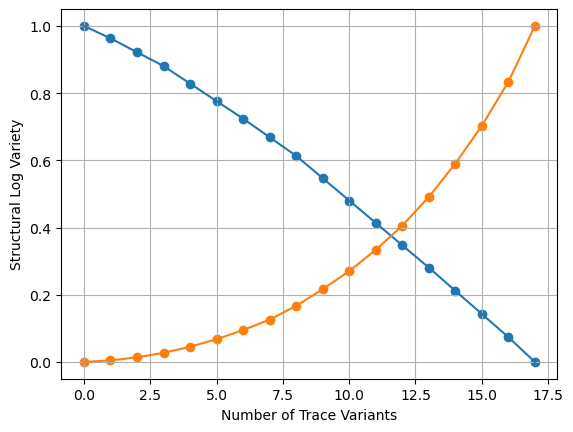

In [39]:
# Label für die y-Achse vergeben:
plt.ylabel('Structural Log Variety')
plt.xlabel('Number of Trace Variants')


x = list(range(0, len(cophenet_matrix)))
y = varDecrease(variety, margVar)
y = y / max(y) #normalization

y2 = alignIncrease(margAlignCosts)
y2 = y2 / max(y2) #normalization

# Einen x-y-Plot erstellen:
plt.plot(x, y)
plt.plot(x, y2)

# plot scatter plot with x and y data 
plt.scatter(x, y)
plt.scatter(x, y2)

# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])

# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)

# Diagramm anzeigen:
plt.show()

## Baseline - based on random selection

In [40]:
#Derive ordering of traces based on random selection
import math

def marginal_variety_baseline(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    numbVar = len(pairwise_distances)
    remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(numbVar-1):
        #print(modified_distances)
        
        #Select random variant to be removed
        indices = np.random.choice(remaining)
        remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        #print(indices, min_val, remaining)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
        
    #return modified_distances
    return traceOrder, margVariety, totalVariety #modified_distances


marginal_variety_baseline(Matrix)

C:\Users\la1949\AppData\Local\Temp\ipykernel_14312\2385287758.py:38: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


([11, 2, 3, 1, 0, 7, 12, 5, 15, 6, 10, 14, 16, 9, 8, 4, 13],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  2.0,
  1.0,
  2.0],
 [19.0,
  18.0,
  17.0,
  16.0,
  15.0,
  14.0,
  13.0,
  12.0,
  11.0,
  10.0,
  10.0,
  8.0,
  6.0,
  6.0,
  6.0,
  4.0,
  4.0])

In [42]:
#Change in Variety
order, margVar, totalVar = marginal_variety_baseline(Matrix)
margAlignCosts = marginal_alignments(Matrix, order)
print(margAlignCosts)

totalVar.append(0)
print(totalVar)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 11.0, 12.0, 14.0, 16.0, 17.0, 18.0, 23.0, 28.0, 41.0]
[19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 12.0, 13.0, 12.0, 10.0, 8.0, 8.0, 8.0, 6.0, 4.0, 0]


C:\Users\la1949\AppData\Local\Temp\ipykernel_14312\2385287758.py:38: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


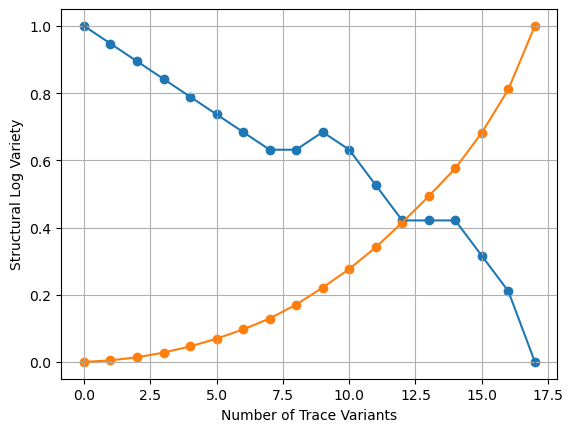

In [43]:
# Label für die y-Achse vergeben:
plt.ylabel('Structural Log Variety')
plt.xlabel('Number of Trace Variants')


x = list(range(0, len(cophenet_matrix)))
y = totalVar
y = y / max(y) #normalization

y2 = alignIncrease(margAlignCosts)
y2 = y2 / max(y2) #normalization

# Einen x-y-Plot erstellen:
plt.plot(x, y)
plt.plot(x, y2)

# plot scatter plot with x and y data 
plt.scatter(x, y)
plt.scatter(x, y2)

# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])

# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)

# Diagramm anzeigen:
plt.show()

In [47]:
totalVar

[19.0,
 18.0,
 17.0,
 16.0,
 15.0,
 14.0,
 13.0,
 12.0,
 12.0,
 13.0,
 12.0,
 10.0,
 8.0,
 8.0,
 8.0,
 6.0,
 4.0,
 0]